## 1. Introduction

This notebook is to perform preprocessing, modeling and hyperparameter tuning for the churn prediction problem at ABC Bank. The previous noteboo on EDA looked at relationships between different variables and customer churn. The key takeaways were:

1. France has twice as many customers, but the number of customers who churn is similar to Germany and Spain. So, customers in Germany and Spain have a higher risk of churning
2. The median age of churners is a little bit higher than those who do not churn
3. Members who are active are less likely to churn
4. Only 20% of the customers churned. So, there is imbalance in the dataset as there is 80% of one class and 20% of the other
5. Number of products and Age seem to have the highest correlation while Activness, Balance and tenure have moderate correlation with customer churn.¶
6. Balance has good correlation with geography and number of products

## 2. Imports

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

#import classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#parameters, metrics and tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import matthews_corrcoef,roc_curve,roc_auc_score
from sklearn.metrics import make_scorer #to make custom scoring function

# To handle imbalance in dataset
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [2]:
#importing data
churn_data=pd.read_csv("../raw data/Churn_data.csv")

In [3]:
#Printing first 5 rows:
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Dropping unwanted rows: Row number, Customer ID and Surname
churn_data.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)
churn_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
#Checking the data types
churn_data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## Creating dummy variables for categorical columns

In [6]:
#Creating dummy variables so that the algorithm can understand the features and dropping first to ensure there is no multicollinearity
churn_data=pd.get_dummies(churn_data,columns=["Geography","Gender"],drop_first=True)
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## Splitting the dataset to get X and y

In [7]:
X=churn_data.drop(["Exited"],axis=1)
y=churn_data["Exited"]
print(X.shape,y.shape)

(10000, 11) (10000,)


## Splitting the dataset into training and testing

In [8]:
#Splitting into train and  test and stratify based on y so that tht proportion of churn is same in train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8000, 11) (8000,) (2000, 11) (2000,)


## Applying oversampling on training

In [9]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [10]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

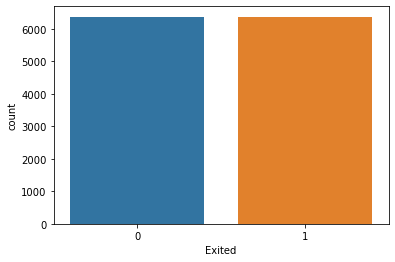

In [11]:
#to confirm both vlasses have same number of values
sns.countplot(x=y_train)
plt.show()

## Standardizing the dataset

In [12]:
#The next step is to standardizethe features so that they are all in the same range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train) # fits to training mean and standard deviation and also transforms it
X_test=scaler.transform(X_test)

## Setting up the evaluation metric

In this case, it is critical to reduce both False positives and False negtives. So, the Matthew's correlation coefficient is chosen as the metric to evaluate all models. The confusion matrix will help in visaulizing how good the model is at classifying each category.

In [13]:
#scoring function for all models
mcc_scorer=make_scorer(matthews_corrcoef)

## Default KNN Classifier

In [14]:
#Fitting the default KNN classifier
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train) 

KNeighborsClassifier()

Matthews correlation coefficient = 0.33528


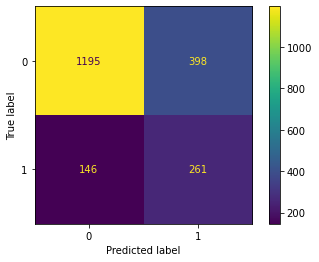

In [15]:
#Model evaluation 
y_pred=knn_clf.predict(X_test)
print('Matthews correlation coefficient = {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
plot_confusion_matrix(knn_clf, X_test, y_test,values_format='d')  
plt.show()

## KNN Classifier - Hyperparameter tuning

In [16]:
hyperparamter_grid={"n_neighbors":[10,25,50,100,200],
                   'weights':['uniform','distance'],
                   'leaf_size':[5,10,25,50,75],
                   'p':[1,2]}

In [17]:
knn_clf_rand=RandomizedSearchCV(KNeighborsClassifier(),hyperparamter_grid,scoring=mcc_scorer,n_iter=200, cv=5, n_jobs=-1)
knn_clf_rand.fit(X_train,y_train)
print(f'Best score: {knn_clf_rand.best_score_} with param: {knn_clf_rand.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 100 is smaller than n_iter=200. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.8041791338207795 with param: {'weights': 'distance', 'p': 1, 'n_neighbors': 100, 'leaf_size': 5}


Matthews correlation coefficient = 0.47107


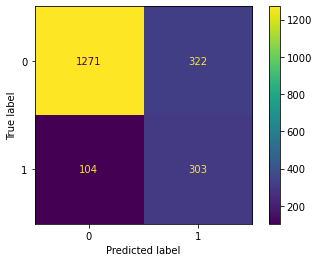

In [18]:
#Model evaluation 
sns.reset_orig()
y_pred=knn_clf_rand.predict(X_test)
knn_test_score=matthews_corrcoef(y_test,y_pred)
print('Matthews correlation coefficient = {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
plot_confusion_matrix(knn_clf_rand, X_test, y_test,values_format='d')  
plt.show() 

## Logistic Regression - Hyperparameter tuning

In [19]:
#https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
# define hyperparameters
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"penalty": ["none","l1","l2"],
                   "C": crange,
                   "fit_intercept": [True, False],
                  "solver":["lbfgs","liblinear"]}

In [20]:
# logistic model classifier
# define evaluation procedure
log_clf_rand = RandomizedSearchCV(LogisticRegression(),hyperparam_grid,scoring=mcc_scorer,n_iter=250, cv=5, n_jobs=-1)
log_clf_rand.fit(X_train,y_train)
print(f'Best score: {log_clf_rand.best_score_} with param: {log_clf_rand.best_params_}')

Best score: 0.4073086393449749 with param: {'solver': 'liblinear', 'penalty': 'l1', 'fit_intercept': True, 'C': 6.5}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.40715    0.40715    0.40715    0.40584969
        nan 0.40584969 0.40715    0.40584969        nan        nan
 0.40584969 0.40715    0.40715    0.40584969 0.40715    0.40715
 0.40715           nan 0.40584969 0.40715    0.40715           nan
 0.40631326        nan 0.40584969 0.40715           nan 0.40584969
 0.40584969        nan        nan 0.40715           nan 0.40715
 0.40631326        nan        nan        nan 0.40678581 0.40584969
 0.40715           nan 0.40715    0.40715    0.40715    0.40715
 0.40584969        nan        nan 0.40730864 0.40715           nan
 0.40584969        nan 0.40584969 0.40715    0.40715    0.40600816
 0.40647173 0.40584969        nan        nan        nan 0.40715
 0.40584969 0.40715    0.40715    0.40730864 0.40677829 0.40715
        nan 0.40584969 0.40715           nan        nan 0.40584969
 

Matthews correlation coefficient = 0.34432


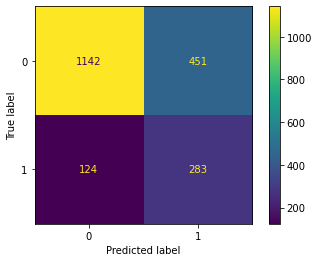

In [21]:
#Model evaluation 
y_pred=log_clf_rand.predict(X_test)
log_test_score=matthews_corrcoef(y_test,y_pred)
print('Matthews correlation coefficient = {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
plot_confusion_matrix(log_clf_rand, X_test, y_test,values_format='d')  
plt.show()

In [22]:
x=churn_data.drop("Exited",axis=1)
coefficients_logistic=pd.DataFrame({"feature":x.columns,"coefficient":log_clf_rand.best_estimator_.coef_[0]})
coefficients_logistic.head()

,feature,coefficient
0,CreditScore,-0.063423
1,Age,0.849449
2,Tenure,-0.045839
3,Balance,0.191584
4,NumOfProducts,-0.060260


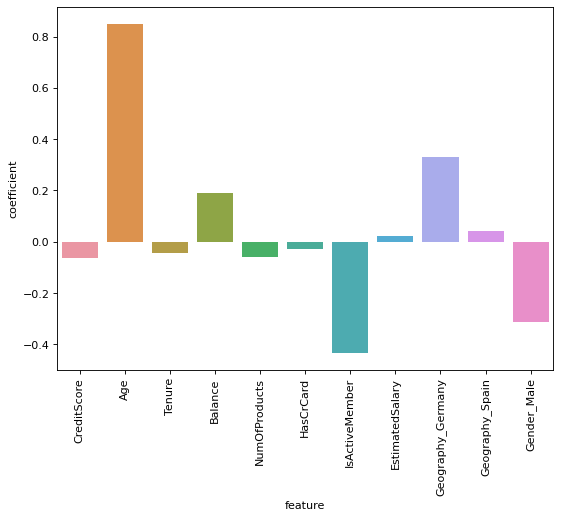

In [23]:
figure(figsize=(8, 6), dpi=80)
sns.barplot(data=coefficients_logistic,x="feature",y="coefficient")
plt.xticks(rotation=90)
plt.show()

## Random forest - Hyperparameter tuning

In [24]:
#Defining the hyperparmater space for random forest
hyperparamter_grid={"n_estimators":[5,10,25,50,100,200],
                   "criterion":["gini", "entropy"],
                   "max_depth":[1,2,3,4,5,8,10],
                   "bootstrap":[True,False]}

In [25]:
#Fiting the random forest through randomized search
rand_clf=RandomForestClassifier()
rand_forest_rand=RandomizedSearchCV(rand_clf,hyperparamter_grid,scoring=mcc_scorer,n_iter=250, cv=5, n_jobs=-1)
rand_forest_rand.fit(X_train,y_train)
print(f'Best score: {rand_forest_rand.best_score_} with param: {rand_forest_rand.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 168 is smaller than n_iter=250. Running 168 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.7344317929862091 with param: {'n_estimators': 200, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}


Matthews correlation coefficient = 0.50873


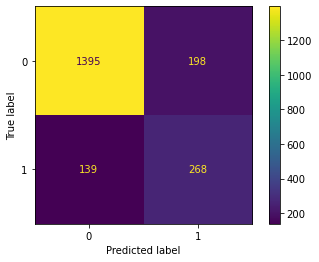

In [26]:
#Model evaluation 
sns.reset_orig()
y_pred=rand_forest_rand.predict(X_test)
rf_test_score=matthews_corrcoef(y_test,y_pred)
print('Matthews correlation coefficient = {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
plot_confusion_matrix(rand_forest_rand, X_test, y_test,values_format='d')
plt.show()

## XGBoost - Hyperparameter tuning

In [34]:
# A parameter grid for XGBoost
hyperparamter_grid = {"n_estimators":[5,10,25,50,100],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [1,2,3,4,5,8,10],
          'learning_rate':[0.001,0.01,0.05,0.1]
         }

In [35]:
xgb_clf = XGBClassifier(objective='binary:logistic',nthread=-1)
xgb_rand=RandomizedSearchCV(xgb_clf,hyperparamter_grid,scoring=mcc_scorer,n_iter=250, cv=5, n_jobs=-1)
xgb_rand.fit(X_train,y_train)
print(f'Best score: {xgb_rand.best_score_} with param: {xgb_rand.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.8730253224592129 with param: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


Matthews correlation coefficient = 0.50167


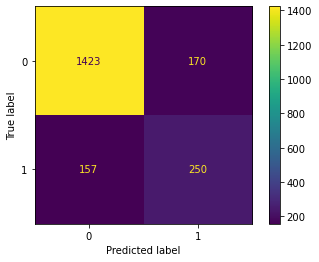

In [41]:
#Model evaluation 
sns.reset_orig()
y_pred=xgb_rand.predict(X_test)
xgb_test_score=matthews_corrcoef(y_test,y_pred)
print('Matthews correlation coefficient = {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
plot_confusion_matrix(xgb_rand, X_test, y_test,values_format='d')
plt.show()

## Comparing ROC metric for all models

We can also look at the ROC metric for all models to see how they perform

In [42]:
#Function to plot a roc curve for a classifier 
def plt_rocs(classifier,label):
    y_pred=classifier.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label=label+" auc="+str(round(auc,2)))

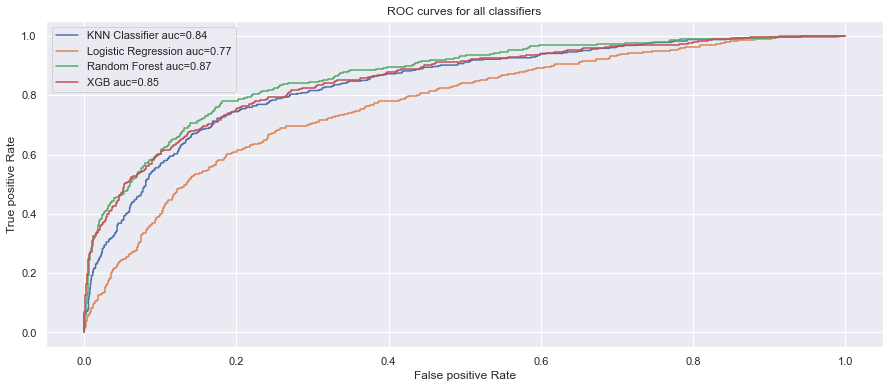

In [43]:
sns.set()
figure(figsize=(15,6))
plt_rocs(knn_clf_rand,"KNN Classifier")
plt_rocs(log_clf_rand,"Logistic Regression")
plt_rocs(rand_forest_rand,"Random Forest")
plt_rocs(xgb_rand,"XGB")
plt.legend(loc='best')
plt.title("ROC curves for all classifiers")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.show()

## 4.8 Model selection

Now, it is time to comapre the performance of all models that have been trained so far and pick the one that would be used in making predictions.

In [44]:
model_selection=pd.DataFrame({"Type of Classifier":["KNN","Logistic Regression","Random Forest","XGBoost"],
                             "training scores":[knn_clf_rand.best_score_,log_clf_rand.best_score_,rand_forest_rand.best_score_,xgb_rand.best_score_],
                             "testing scores":[knn_test_score,log_test_score,rf_test_score,xgb_test_score]}).round(3)

In [45]:
model_selection

,Type of Classifier,training scores,testing scores
0,KNN,0.804,0.471
1,Logistic Regression,0.407,0.344
2,Random Forest,0.734,0.509
3,XGBoost,0.873,0.502


### Based on the test scores of different models and the consion matrix, the Random forest model is chosen. It helps in correctly identifying 265 out of 398 people who would have exited which is approximately 66%.

## Business Impact

Previously, ABC bank was able to only correctly identify 50% of people who churned. But Using the new model, the prediction accuracy has gone up by 16%.

Of all customers identified as churn, ABC Bank is able to retain about 35% by offering them better incentives and promos. 

The number of customers that would be retained with the new model is (0.35*0.66)-(0.35*0.5) = 0.056

### Using this new model, the churn would reduce by 6% 

## Summary

It is clear from the models that the customers who are higher in age are most likely to exit. The data also shows that inactive members and women are at a higher risk of exiting. Geographically speaking, German customers are exiting at a much higher rate than other countries.

Now that we have identified who is likely to exit, a study has to be done to understand why these customers are exiting.